This notebook plots the initial evolution of biases in 3 runs: a no-ML baseline, a fine-only prognostic run and a n2f prognostic run.

At most vertical levels and latitudes, both the fine-only and n2f prognostic runs have smaller temperature and humidity drifts than the baseline run. In general the n2f drifts are slightly smaller compare to fine-only, e.g. for temperature in the free troposphere (levels 25-60) or specific humidity in the boundary layer.

In [1]:
import numpy as np
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
import vcm
from vcm.catalog import catalog
from vcm.fv3.metadata import gfdl_to_standard
import datetime
import cftime
from dask.distributed import Client
from scipy.interpolate import interp1d
import yaml
plt.rcParams['figure.dpi'] = 200
xr.set_options(keep_attrs=True)

In [2]:
Client()

/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/dashboard/core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==2.2.3.
Continuing without the dashboard.
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45473,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:43781,Total threads: 2
Dashboard: http://127.0.0.1:38677/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:38987,


In [3]:
with open('run_urls.yaml') as f:
    runs = yaml.safe_load(f)

In [4]:
with open('ak.txt') as f:
    ak = list(map(float, f))
with open('bk.txt') as f:
    bk = list(map(float, f))

# reference pressure levels in hPa assuming 1000hPa surface pressure
plev = np.array(ak)/100 + np.array(bk) * 1000  
plev_mid = 0.5 * (plev[:-1] + plev[1:])

f = interp1d(plev_mid, range(0, 79), fill_value='extrapolate')
tick_labels = [3, 100, 300, 500, 700, 850, 1000]
tick_indices = f(tick_labels)

In [5]:
urls = {
    "ML-physics": runs['prog-10day-seed5']['url'],
    "ML-physics-nonudge": runs['prog-nonudge-seed5']['url'],
    "ML-physics-noflux": runs['prog-noflux-seed5']['url'],
}
verif_url = 'gs://vcm-ml-experiments/default/2021-12-16/2020-05-27-40-day-X-SHiELD-simulation-v2/fine-res-budget.zarr'

In [6]:
INIT_TIME = cftime.DatetimeJulian(2016, 8, 5)

In [7]:
grid = catalog['grid/c48'].to_dask().load()

In [8]:
def open_zarr(url):
    return xr.open_zarr(fsspec.get_mapper(url))

In [9]:
ds = []
for name, url in urls.items():
    tmp = open_zarr(url + '/state_after_timestep.zarr')
    ds.append(tmp.assign_coords(run=name))
ds = xr.concat(ds, dim='run', join='inner')

In [10]:
verif = open_zarr(verif_url)
verif = gfdl_to_standard(verif).drop('tile')
verif['time'] = verif.time + datetime.timedelta(minutes=7, seconds=30)
verif = verif.rename(
    T='air_temperature', sphum='specific_humidity', delp='pressure_thickness_of_atmospheric_layer',
    LHTFLsfc_coarse='latent_heat_flux', SHTFLsfc_coarse='sensible_heat_flux'
)

In [11]:
variables = ['air_temperature', 'specific_humidity', 'pressure_thickness_of_atmospheric_layer', 'sensible_heat_flux', 'latent_heat_flux']

In [12]:
ds_all = xr.concat([ds[variables], verif[variables].assign_coords(run='verif')], dim='run', join='inner')

In [13]:
global_mean = vcm.weighted_average(ds_all, grid.area).compute()

In [14]:
global_mean['air_temperature'].attrs = {'long_name': 'Air temperature', 'units': 'K'}

In [15]:
error = global_mean - global_mean.sel(run='verif')
error = error.isel(run=slice(3))
error = xr.concat([xr.zeros_like(error.isel(time=0)).assign_coords(time=INIT_TIME), error], dim='time')
error['time'] = (error.time - error.time[0]).values / np.timedelta64(1, 'h')
error.time.attrs['units'] = 'hours elapsed'

### Plot global mean error as function of model level and time
Showing first 3 days of simulations

In [16]:
def plot_three_panel(da, set_xticks=True, **kwargs):
    fg = da.plot(y='z', yincrease=False, col='run', **kwargs)
    fg.fig.set_size_inches((12, 3))
    if set_xticks:
        for ax in fg.axes.flat:
            ax.set_xticks(range(0, 73, 24))

Showing first 10 days

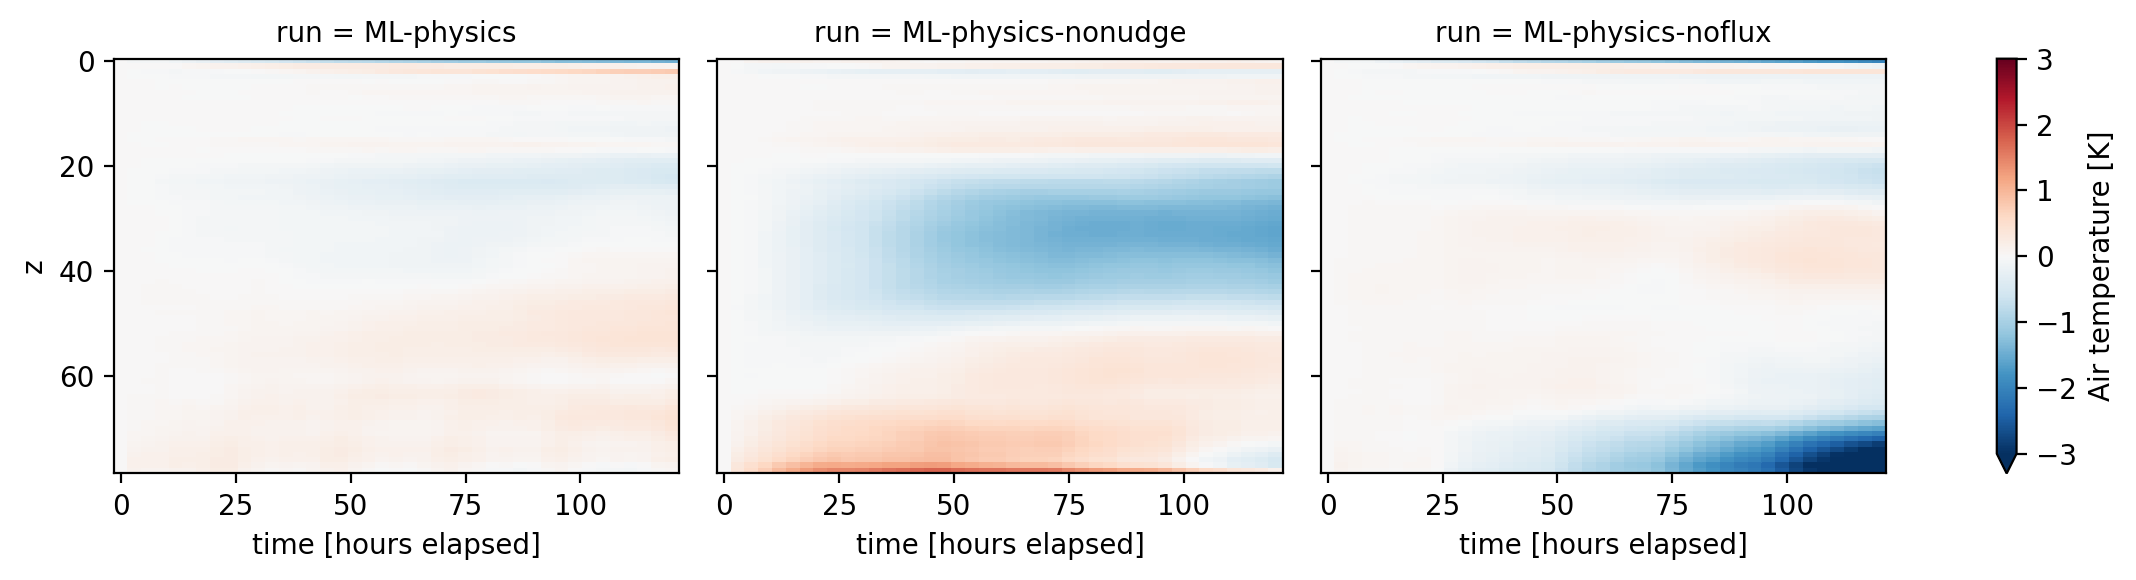

In [17]:
plot_three_panel(error.air_temperature.sel(time=slice(0, 120)), set_xticks=False, vmin=-3, vmax=3, cmap='RdBu_r')

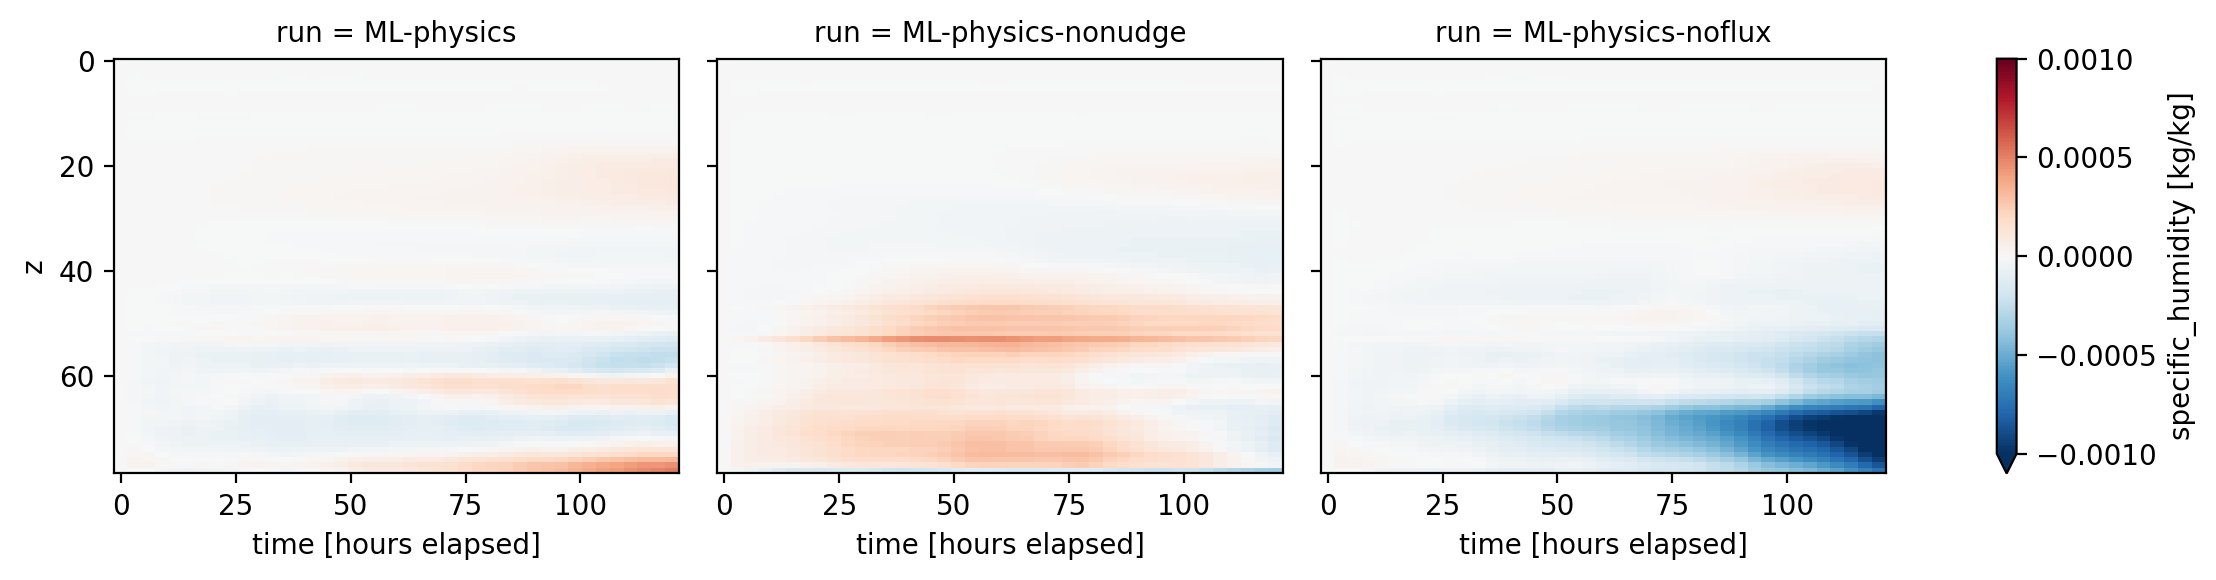

In [18]:
plot_three_panel(error.specific_humidity.sel(time=slice(0, 120)), set_xticks=False, vmin=-0.001, vmax=0.001, cmap='RdBu_r')

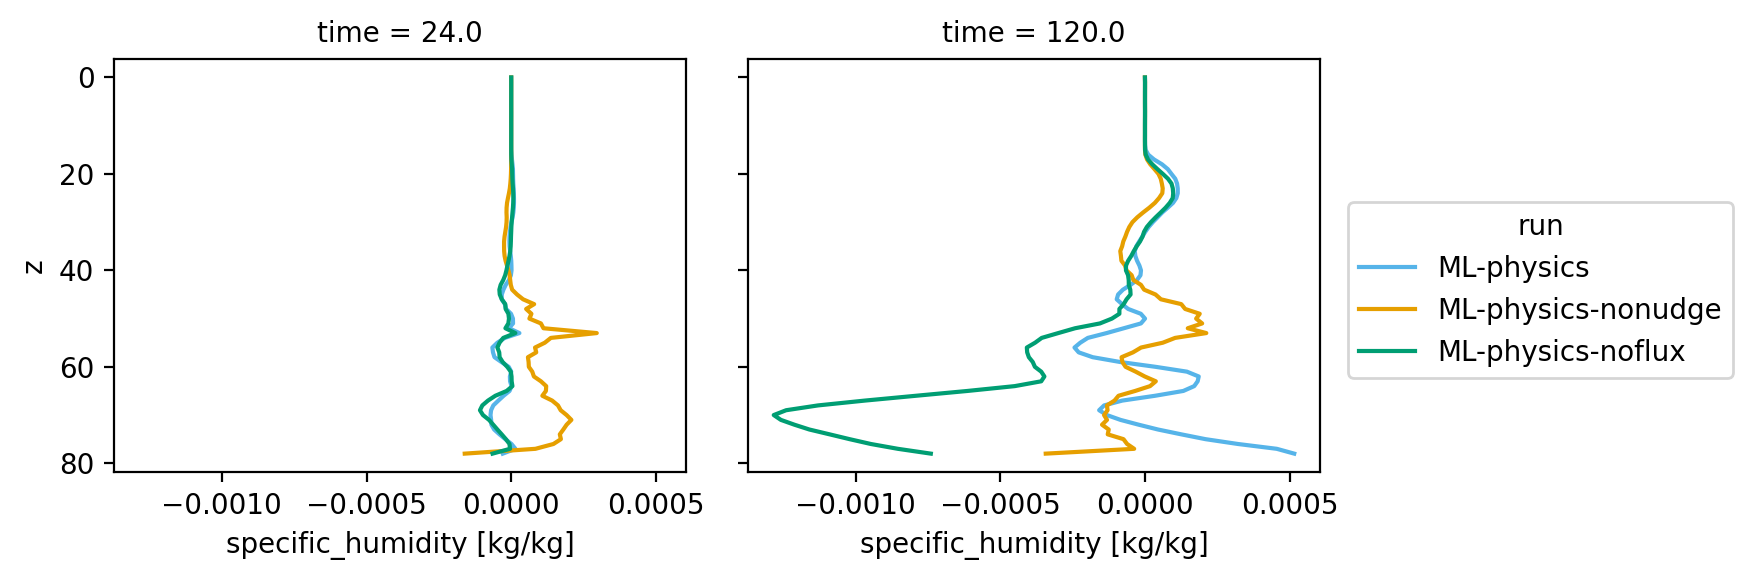

In [19]:
error.specific_humidity.isel(time=[8, 40]).plot(y='z', hue='run', yincrease=False, col='time')

Text(0.5, 1.0, 'time elapsed = 4 days')

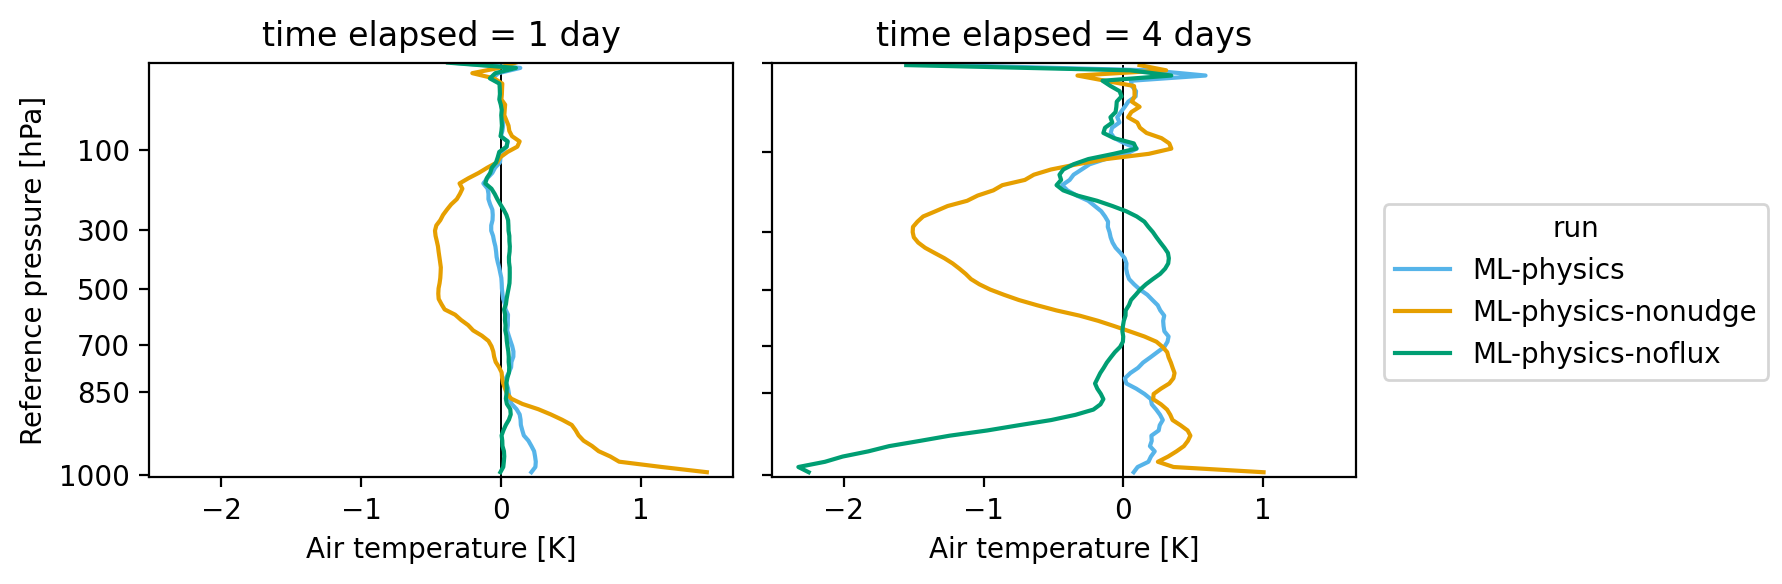

In [20]:
fg = error.air_temperature.isel(time=[8, 32]).plot(y='z', hue='run', yincrease=False, col='time')
for ax in fg.axes.flat:
    #ax.grid()
    ax.vlines(0, 0, 79, linewidth=0.7)
    ax.set_ylim([79, 0])
    ax.set_yticks(tick_indices)
fg.axes.flat[0].set_yticklabels(tick_labels)
fg.axes.flat[0].set_ylabel('Reference pressure [hPa]')
fg.axes.flat[0].set_title('time elapsed = 1 day')
fg.axes.flat[1].set_title('time elapsed = 4 days')